<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Position Concentration Risk

By Maxwell Margenot and Delaney Granizo-Mackenzie

When trading, it is important to diversify your risks. By concentrating your positions in only a few assets, you can negatively be impacted by their risks. This notebook is designed to show how diversifying your portfolio can result in a lower overall risk profile.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Intuition

Let's say you learned to card count at Blackjack, whereas most casinos will throw you out if you are caught, it will give you a [1% edge over the house](https://en.wikipedia.org/wiki/Card_counting). If you walked into the casino with \$10,000 to bet, it would clearly be insane to place all the money on one game. Whereas you have a 51\% chance of winning that game, the house still has a 49\% chance. The expected outcome is for you to win the game, but the variance is incredibly high.

Let's say you placed your money on 100 different tables. This is known as making independent bets, because the outcome of one table doesn't affect any of the others. Your variance will be reduced as you make more and more bets. You would still expect to win 51\% of the tables, but the chance of losing money is greatly reduced. Let's see this in action.

### Simulating Blackjack Games

Each game will be won with a 51% probability. We can simulate this using a binomial distribution, which is parameterized with the number of trials we perform (games), and the chance of each trial succeeding.

First we'll simulate 1000 different universes in which you walk into the casino and play one game.

In [2]:
universes = 1000

results = np.zeros((universes, 1))
for i in range(universes):
    results[i] = np.random.binomial(n=1, p=0.51)

Now let's check the mean and standard deviation of the results. We see that because there are so many 0s and so many 1s, and nothing in between, the standard deviation is very high. This is saying that you should expect to win half a game, with the potential outcomes being approximately evenly distributed between a loss and a win. Because you played so few games, you have given no time for your edge to work.

In [3]:
np.mean(results), np.std(results)

(0.508, 0.49993599590347565)

Now let's simulate 1000 universes in which you walk into the casino and play 100 games.

In [4]:
universes = 1000

results = np.zeros((universes, 1))
for i in range(universes):
    results[i] = np.random.binomial(n=100, p=0.51)

np.mean(results), np.std(results)

(50.752, 4.907595745372677)

Now we see that the average result is much closer to 51 games won, with a smaller standard deviation. We see here that you're likely still not safe, as your expected edge is only one game, whereas the standard deviation is many games. This would indicate that you can reasonably expect to lose more games than you win. Finally let's try 10,000 games.

In [5]:
universes = 1000

results = np.zeros((universes, 1))
for i in range(universes):
    results[i] = np.random.binomial(n=10000, p=0.51)

np.mean(results), np.std(results)

(5100.671, 51.15506581952563)

In this case we're much safer, as the expected edge is 100 games.

NOTE: There is a subtlety that it's not always valid to use a standard deviation, as the underlying distribution of data in this case is not normal. We use it here because standard deviation is the metric of volatility used in finance, and it still reflects how much 'spread' exists in the data. Be careful not to abuse standard deviation in practice by assuming the underlying data is normal.

## Expanding to Portfolio Theory

The same exact principle exists in portfolio theory. If you think you have an edge over the market in picking stocks that will go up or down, you should try to make as many independent bets as possible. This can be accomplished by investing in as many uncorrelated assets as possible. Let's take a look at an example.

Remember that in finance, volatility is measured by the standard deviation of a time series, and the amount of future risk of a portfolio is estimated by past portfolio volatility.

### Case 1: Investing in Few Assets

Let's simulate some assets by sampling from a normal distribution.

NOTE: In practice real financial asset returns rarely are normally distributed, so this is not a great assumption. However it's okay here to get our point across because we are just concerned with correlation and level of volaility.

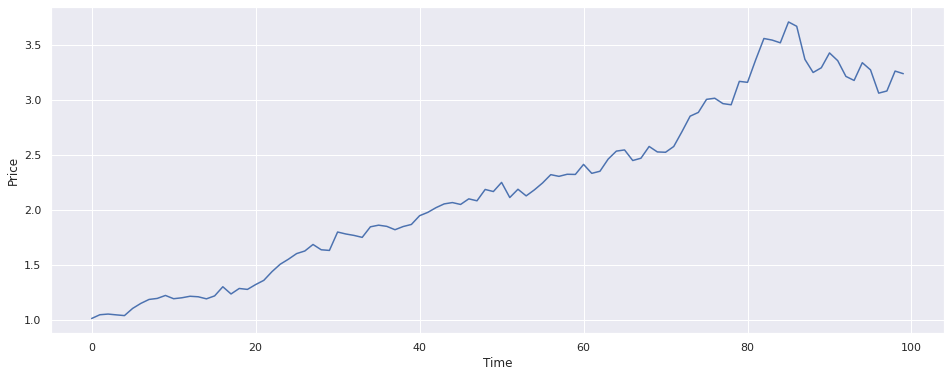

In [6]:
R_1 = np.random.normal(1.01, 0.03, 100)
A_1 = np.cumprod(R_1)
P = A_1
plt.plot(P)
plt.xlabel('Time')
plt.ylabel('Price');

In this case, we're totally exposed to the volatility of that asset, as our portfolio is entirely that asset.

### Case 2: Investing in Many Correlated Assets

In this case we expand our asset pool, but there is still a large amount of pairwise correlation between the returns. We simulate this by simulating assets 2 through N as asset 1 plus some noise.

Asset Volatilities
[0.03274246990515077, 0.033634304029958935, 0.03388511407859658, 0.03400714304316729, 0.0356984557402864, 0.033448077174547064, 0.03384719884248031, 0.03406870231160882, 0.03397867754596142, 0.03469150512143593]
Mean Asset Volatility
0.03400016477931935
Portfolio Volatility
0.032796399987089886


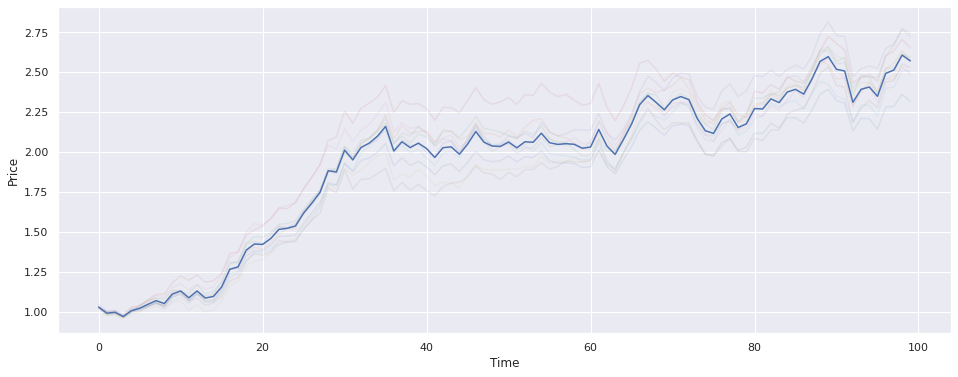

In [7]:
N = 10

returns = np.zeros((N, 100))
assets = np.zeros((N, 100))

R_1 = np.random.normal(1.01, 0.03, 100)
returns[0] = R_1
assets[0] = np.cumprod(R_1)
plt.plot(assets[0], alpha=0.1)

for i in range(1, N):
    R_i = R_1 + np.random.normal(0.001, 0.01, 100)
    returns[i] = R_i
    assets[i] = np.cumprod(R_i)
    
    plt.plot(assets[i], alpha=0.1)

R_P = np.mean(returns, axis=0)
P = np.mean(assets, axis=0)
plt.plot(P)
plt.xlabel('Time')
plt.ylabel('Price');

print('Asset Volatilities')
print([np.std(R) for R in returns])
print('Mean Asset Volatility')
print(np.mean([np.std(R) for R in returns]))
print('Portfolio Volatility')
print(np.std(R_P))

Here you can see the portfolio accompanied by all the assets, the assets being drawn much softer. The important thing to note is that the portfolio undergoes all the same shocks as the assets, because when one asset is up or down, all the others are likely to be so as well. This is the problem with correlated assets. Let's take a look at the volatility of the assets and the volatility of the portfolio.

The mean volatility of our assets is the same as the portfolio volatility. We haven't gained anything by making more bets. You can think of correlated bets as identical to the original bet. If the outcome of the second bet is correlated with the first, then really you've just made the same bet twice and you haven't reduced your volatility.

### Case 3: Investing in Many Uncorrelated Assets

In this case we independently generate a bunch of assets an construct a portfolio that combines all of them.

Asset Volatilities
[0.03191972074897833, 0.028197779899151725, 0.030748164162362306, 0.02853332660593513, 0.030824399009462978, 0.033823135656583424, 0.034183696368804015, 0.026630556653008394, 0.03725443077713348, 0.030500268282548745]
Mean Asset Volatility
0.031261547816396854
Portfolio Volatility
0.009106875408305775


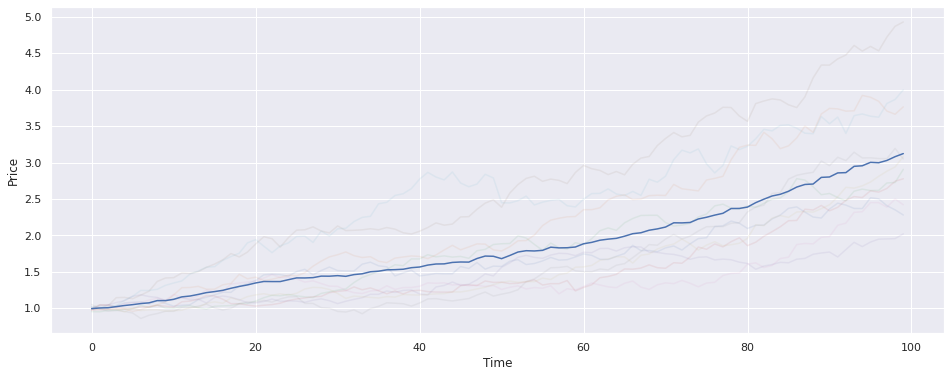

In [8]:
N = 10

assets = np.zeros((N, 100))
returns = np.zeros((N, 100))

for i in range(N):
    R_i = np.random.normal(1.01, 0.03, 100)
    returns[i] = R_i
    assets[i] = np.cumprod(R_i)
    
    plt.plot(assets[i], alpha=0.1)

R_P = np.mean(returns, axis=0)
P = np.mean(assets, axis=0)
plt.plot(P)
plt.xlabel('Time')
plt.ylabel('Price');

print('Asset Volatilities')
print([np.std(R) for R in returns])
print('Mean Asset Volatility')
print(np.mean([np.std(R) for R in returns]))
print('Portfolio Volatility')
print(np.std(R_P))

Now we see the benefits of diversification. Holding more uncorrelated assets smooths out our portfolio. When one is down, the others are no more likely to be down, so the bumps both upwards and downwards are often much smaller. The more assets we hold, the more we'll reduce our volatility as well. Let's check that.

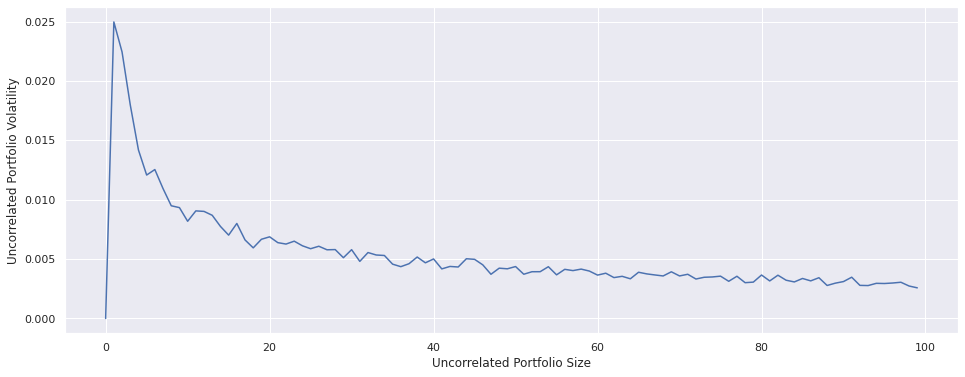

In [9]:
portfolio_volatilities_by_size = np.zeros((100,1))

for N in range(1,100):

    assets = np.zeros((N, 100))
    returns = np.zeros((N, 100))

    for i in range(N):
        R_i = np.random.normal(1.01, 0.03, 100)
        returns[i] = R_i

    R_P = np.mean(returns, axis=0)

    portfolio_volatilities_by_size[N] = np.std(R_P)
    
plt.plot(portfolio_volatilities_by_size)
plt.xlabel('Uncorrelated Portfolio Size')
plt.ylabel('Uncorrelated Portfolio Volatility');

## Final Point

Be invested in as many uncorrelated assets as possible. In finance this is known as diversification. If you have a pricing model, price everything and invest accordingly. This concept is explained in the Long-Short Equity Lecture.

## Capital Constraints

Because of transaction costs, you need to have certain minimum amounts of capital to invest in large numbers of assets. Therefore sometimes you are unable to invest in hundreds or thousands. In this case you should still try to maximize your portfolio size, keeping in mind that if you have a portfolio of size 20, you can still find 20 relatively uncorrelated assets and that's better than nothing.

## Now Let's Explain with Math Rather Than Pictures

One of the key aspects of modern portfolio theory is that by combining multiple assets into a portfolio, you can reduce the entire package's overall risk. Since we represent the volatility of an asset by its standard deviation, we can easily show this mathematically.

Say that we have two assets in a portfolio, $S_1$ and $S_2$, with weights $\omega_1$ and $\omega_2$ such that $\omega_1 + \omega_2 = 1$. Call the portfolio $P$ and say that $S_1$ and $S_2$ have mean and standard deviation $\mu_1, \sigma_1$ and $\mu_2, \sigma_2$ respectively. We can calculate the value of $P$ easily.

$$ P = \omega_1 S_1 + \omega_2 S_2 $$

Now we set $\mu_P$ as the return of the portfolio $P$. It is simple to calculate the expected return of this portfolio:

$$ E[\mu_P] = E[\omega_1 \mu_1 + \omega_2 \mu_2] = \omega_1 E[\mu_1] + \omega_2 E[\mu_2] $$

As you can see, the expected return of the overall portfolio can be directly determined using the expected returns of the assets *in* the portfolio as well as their associated weights. Similarly, we can use these same characteristics to determine the overall risk of the portfolio, $\sigma_p$. First, we calculate the variance of the portfolio, $\sigma_p^2 = VAR[P]$. Then we say that the correlation between $S_1$ and $S_2$ is $COR[S_1,S_2] = \frac{COV[S_1,S_2]}{\sigma_1\sigma_2} = \rho_{12}$. The calculations then follow:

\begin{eqnarray}
\sigma_p^2 &=& VAR[P] \\
    &=& VAR[\omega_1 S_1 + \omega_2 S_2] \\
    &=& VAR[\omega_1 S_1] + VAR[\omega_2 S_2] + COV[\omega_1 S_1,\omega_2 S_2] \\
    &=& \omega_1^2 VAR[S_1] + \omega_2^2 VAR[S_2] + 2\omega_1\omega_2 COV[S_1,S_2] \\
    &=& \omega_1^2 \sigma_1^2 + \omega_2^2 \sigma_2^2 + 2\rho_{12}\omega_1\omega_2\sigma_1\sigma_2
\end{eqnarray}

In [10]:
stocks = np.array([100, 75])
mean_returns = np.array([4, 6])

r_12 = 0.20
cov_12 = r_12 * 0.05 * 0.08
covariance_matrix = np.array([[0.05**2,cov_12],[cov_12,0.08**2]])

weights = np.array([0.7, 0.3])

P = np.dot(weights, stocks.T)

Now we will calculate the overall risk of the portfolio:

In [11]:
var_p = np.dot(np.dot(weights, covariance_matrix), weights.T)
sigma_p = np.sqrt(var_p)
print("The overall risk of the portfolio is", sigma_p)

The overall risk of the portfolio is 0.04622769732530488


By combining assets into a portfolio, we were able to create a package with lower overall risk than either of the individual assets. If we include even more assets in the portfolio we can further reduce the risk of exposure to any individual asset.

## Benefits Of Additional Bets

We can extend this idea to a portfolio made of of $n$ securities fairly easily. The more assets you include in your portfolio, the lower your overall risk will be. Here is the general form for the variance of your portfolio in the case where you have $n$ assets:

$$ \sigma_p^2 = \sum_i \omega_i^2 \sigma_i^2 + \sum_i\sum_{j\neq i} \omega_i\omega_j\sigma_i\sigma_j\rho_{ij}, \ i, j \in \lbrace 1,\ldots, n\rbrace $$

These benefits can be increased by ensuring that your assets are independent from each other. When two assets are independent, they are uncorrelated, i.e. $\rho_{ij}=0$. The correlation between each pairwise set of assets plays a very important part in our calcuations for determining the variance of a portfolio. The higher the correlations between assets, the more assets we need to include to reduce our risk by a comparable amount.

In [12]:
stocks = np.array([230, 176, 192, 105])
mean_returns = np.array([2.0, 3.5, 7.5, 5.0])
std_dev = np.array([0.05, 0.07, 0.11, 0.09])
weights = np.array([0.35, 0.30, 0.15, 0.20])


r_12 = 0.2
r_13 = 0.08
r_14 = 0.1
r_23 = 0.6
r_24 = 0.4
r_34 = 0.8
covariance_matrix = np.array([[0.05**2, r_12 * 0.05 * 0.07, r_13 * 0.05 * 0.11, r_14 * 0.05 * 0.09],
                             [r_12 * 0.05 * 0.07, 0.07**2, r_23 * 0.07 * 0.11, r_24 * 0.07 * 0.09],
                             [r_13 * 0.05 * 0.11, r_23 * 0.07 * 0.11, 0.11**2, r_34 * 0.11 * 0.09],
                             [r_14 * 0.05 * 0.09, r_24 * 0.07 * 0.09, r_34 * 0.11 * 0.09, 0.09**2]])


In [13]:
var_p = np.dot(np.dot(weights, covariance_matrix), weights.T)
sigma_p = np.sqrt(var_p)
print("The overall risk of the portfolio is:", sigma_p)

The overall risk of the portfolio is: 0.052849787132967715


Now let's assume that the correlations between all of these assets are $0$, that they are all pairwise independent. We will assume that everything else remains the same as before. Using our calcualtions for the portfolio's risk we get:

In [14]:
covariance_matrix = np.array([[0.05**2, 0, 0, 0],
                             [0, 0.07**2, 0, 0],
                             [0, 0, 0.11**2, 0],
                             [0, 0, 0, 0.09**2]])
var_p = np.dot(np.dot(weights, covariance_matrix), weights.T).flatten()
sigma_p = np.sqrt(var_p)
print("The overall risk of the portfolio is:", sigma_p)

The overall risk of the portfolio is: [0.03665379]


We were able to significantly reduce the overall risk of the portfolio simply by selecting for assets that were independent of each other. While you are still able to reduce your risk by adding assets that are correlated, you will need to add a greater number of assets in order to have the same effect as with uncorrelated assets.

The following function will allow you to randomly generate a portfolio of arbitrary length:

In [15]:
# Generate an almost entirely random portfolio
# Only constraint is that an asset's variance
def generate_portfolio(n = 5):
    assets = np.random.normal(100, 20, n)
    weights = np.random.uniform(0, 1, n)
    weights = weights/sum(weights)
    returns = np.random.normal(5, 2, n) # Say that 5 is the average return for our assets
    # Generate covariance matrix for assets
    cov_matrix = np.ndarray(shape = (n, n))
    std_dev = np.zeros(n)
    for i in range(n):
        for j in range(i + 1):
            if j == i:
                std_dev[i] = returns[i]/100
                cov_matrix[i][j] = std_dev[i]**2
            else:
                cov_matrix[i][j] = np.random.uniform(-1, 1)
                cov_matrix[j][i] = cov_matrix[i][j]
    # Ensures that the covariance matrix is symmetric
    # Serves the double purpose of squaring the volatility (already present in the matrix) so we get variance
    return weights, assets, returns, std_dev, cov_matrix

We can now use this function to randomly generate a set of assets, each with a different return, as well as a covariance matrix of the assets.

In [16]:
w, S, mu, sigma, cov = generate_portfolio(6)
print("Weights:\n", w)
print("Assets:\n", S)
print("Returns:\n", mu)
print("Volatilities:\n", sigma)
print("\nCovariance Matrix:\n", cov)

Weights:
 [0.08066462 0.06360759 0.30390419 0.15383125 0.10900729 0.28898506]
Assets:
 [ 98.19078418  82.48673074  85.98703404 110.20989827  94.98682376
  87.3887103 ]
Returns:
 [2.7595478  7.63633215 3.49585209 6.66501762 6.69519483 5.3639697 ]
Volatilities:
 [0.02759548 0.07636332 0.03495852 0.06665018 0.06695195 0.0536397 ]

Covariance Matrix:
 [[ 7.61510408e-04 -1.08500762e-01  6.46261197e-01 -4.95911737e-03
  -6.41460609e-01  1.71908464e-01]
 [-1.08500762e-01  5.83135687e-03  1.25166742e-01 -2.31988726e-02
   1.45346179e-01 -3.60191818e-01]
 [ 6.46261197e-01  1.25166742e-01  1.22209819e-03 -5.35738168e-01
   8.85886541e-01  1.94453208e-02]
 [-4.95911737e-03 -2.31988726e-02 -5.35738168e-01  4.44224599e-03
  -5.76165102e-01  9.47006286e-01]
 [-6.41460609e-01  1.45346179e-01  8.85886541e-01 -5.76165102e-01
   4.48256338e-03 -3.41869516e-01]
 [ 1.71908464e-01 -3.60191818e-01  1.94453208e-02  9.47006286e-01
  -3.41869516e-01  2.87721710e-03]]


And now we can easily perform the same calculations that we did before to determine overall portfolio value and risk.

In [17]:
P = np.dot(w, S)
var_p = np.dot(np.dot(w, cov), w.T)
sigma_p = np.sqrt(abs(var_p))
print("Portfolio Value:", P)
print("Portfolio Volatility:", sigma_p)

Portfolio Value: 91.86113868577873
Portfolio Volatility: 0.27611029087373695


Keep in mind that if you choose to change this function at all, you must include some failsafe so that higher returns always correspond to higher volatilites. This is one of the core assumptions of portfolio theory and, while not pertinent here due to our arbitrary weight values, it is essential to calculating the weights of an optimal portfolio.

---

**Next Lecture:** [Estimating Covariance Matrices](Lecture26-Estimating-Covariance-Matrices.ipynb)

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian") or QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, neither Quantopian nor QuantRocket has taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. Neither Quantopian nor QuantRocket makes any guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*